<a href="https://colab.research.google.com/github/The-Powder-of-Data/detecting_deforestation/blob/main/src/notebooks/Semantic_Segmentation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation Model

## Functions

In [ ]:
def mount_bucket(bucket_name):
  """
  This fn authenticates your google account and mounts to you Google Cloud Platform bucket
  """
  !echo "deb http://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
  !curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
  !sudo apt-get -y -q update
  !sudo apt-get -y -q install gcsfuse

  from google.colab import auth
  auth.authenticate_user()
  !mkdir -p gcp_bucket 
  !gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 {bucket_name} gcp_bucket

In [ ]:
def bucket_data_transfer():
  """
  Unzips the jpeg dataset labels csv from our GCP bucket to the correct instance directory as staging for modeling.
  """
  # unzip from CGP bucket to instance
  !unzip /content/gcp_bucket/zip_files/semantic_walkthrough.zip -d {root_directory}
  !cp /content/gcp_bucket/imports/simple_multi_unet_model.py /content/
  !cp /content/gcp_bucket/imports/smooth_tiled_predictions.py /content/
  

In [ ]:
def convert_hex(hex):
  """
  converts HEX string into array of RGB numbers
  """
  output = hex.lstrip('#')
  output = np.array(tuple(int(output[i:i+2], 16) for i in (0,2,4)))
  return output

In [ ]:
def rgb_to_2d_label(label):
  """
  suppy mask lable as rgb
  converts pixels into label id (1,2,3 etc)
  """

  label_seg = np.zeros(label.shape, dtype=np.uint8)
  label_seg[np.all(label == Building, axis=-1)] = 0
  label_seg[np.all(label == Land, axis=-1)] = 1
  label_seg[np.all(label == Road, axis=-1)] = 2
  label_seg[np.all(label == Vegetation, axis=-1)] = 3
  label_seg[np.all(label == Water, axis=-1)] = 4
  label_seg[np.all(label == Unlabeled, axis=-1)] = 5

  # only take first channel, dont need the remaining
  label_seg = label_seg[:,:,0]
  
  return label_seg

In [ ]:
def label_to_rgb(predicted_image):
    """
    converts predicted mask into label rgb colors
    """
    Building = '#3C1098'.lstrip('#')
    Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152
    
    Land = '#8429F6'.lstrip('#')
    Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246
    
    Road = '#6EC1E4'.lstrip('#') 
    Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228
    
    Vegetation =  'FEDD3A'.lstrip('#') 
    Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58
    
    Water = 'E2A929'.lstrip('#') 
    Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41
    
    Unlabeled = '#9B9B9B'.lstrip('#') 
    Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155
    
    segmented_img = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3))
    
    segmented_img[(predicted_image == 0)] = Building
    segmented_img[(predicted_image == 1)] = Land
    segmented_img[(predicted_image == 2)] = Road
    segmented_img[(predicted_image == 3)] = Vegetation
    segmented_img[(predicted_image == 4)] = Water
    segmented_img[(predicted_image == 5)] = Unlabeled
    
    segmented_img = segmented_img.astype(np.uint8)
    return(segmented_img)


## Installs

In [ ]:
! pip install patchify

In [ ]:
!pip install -U segmentation-models
# when do we use pip3??? 

## Connect GCP & Extract Zipped Images

In [ ]:
mount_bucket('jhl_deforestation_project')

deb http://packages.cloud.google.com/apt gcsfuse-bionic main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  74617      0 --:--:-- --:--:-- --:--:-- 74617
OK
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [770 kB]
Get:5 http://packages.cloud.google.com/apt gcsfuse-bionic InRelease [5,391 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://packages.cloud.google.com/apt gcsfuse-

In [ ]:
root_directory = '/content/Semantic_seg_dataset'
bucket_data_transfer()

Archive:  /content/gcp_bucket/zip_files/semantic_walkthrough.zip
  inflating: /content/Semantic_seg_dataset/Semantic segmentation dataset/Tile 1/images/image_part_001.jpg  
  inflating: /content/Semantic_seg_dataset/Semantic segmentation dataset/Tile 1/images/image_part_002.jpg  
  inflating: /content/Semantic_seg_dataset/Semantic segmentation dataset/Tile 1/images/image_part_003.jpg  
  inflating: /content/Semantic_seg_dataset/Semantic segmentation dataset/Tile 1/images/image_part_004.jpg  
  inflating: /content/Semantic_seg_dataset/Semantic segmentation dataset/Tile 1/images/image_part_005.jpg  
  inflating: /content/Semantic_seg_dataset/Semantic segmentation dataset/Tile 1/images/image_part_006.jpg  
  inflating: /content/Semantic_seg_dataset/Semantic segmentation dataset/Tile 1/images/image_part_007.jpg  
  inflating: /content/Semantic_seg_dataset/Semantic segmentation dataset/Tile 1/images/image_part_008.jpg  
  inflating: /content/Semantic_seg_dataset/Semantic segmentation datase

## Imports

In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd

from google.colab import auth #to connect to GCP Bucket

from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image # easier for cropping & resizing
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from simple_multi_unet_model import multi_unet_model, jacard_coef #the unet model w pooling added

from smooth_tiled_predictions import predict_img_with_smooth_windowing


## Process Images & Masks

In [ ]:
scaler = MinMaxScaler()
root_directory = '/content/Semantic_seg_dataset/Semantic segmentation dataset/'
patch_size = 256

In [ ]:
#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = sorted(os.listdir(path)) #List of all image names in this subdirectory... and sort in alphabetical order
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)
                
  
                
  
 #Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = sorted(os.listdir(path))  #List of all image names in this subdirectory... and in alphabetical order
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 
 
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

Now patchifying image: /content/Semantic_seg_dataset/Semantic segmentation dataset/Tile 3/images/image_part_001.jpg
Now patchifying image: /content/Semantic_seg_dataset/Semantic segmentation dataset/Tile 3/images/image_part_002.jpg
Now patchifying image: /content/Semantic_seg_dataset/Semantic segmentation dataset/Tile 3/images/image_part_003.jpg
Now patchifying image: /content/Semantic_seg_dataset/Semantic segmentation dataset/Tile 3/images/image_part_004.jpg
Now patchifying image: /content/Semantic_seg_dataset/Semantic segmentation dataset/Tile 3/images/image_part_005.jpg
Now patchifying image: /content/Semantic_seg_dataset/Semantic segmentation dataset/Tile 3/images/image_part_006.jpg
Now patchifying image: /content/Semantic_seg_dataset/Semantic segmentation dataset/Tile 3/images/image_part_007.jpg
Now patchifying image: /content/Semantic_seg_dataset/Semantic segmentation dataset/Tile 3/images/image_part_008.jpg
Now patchifying image: /content/Semantic_seg_dataset/Semantic segmentati

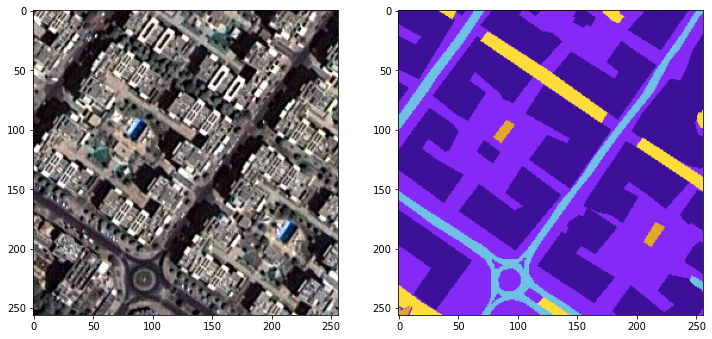

In [ ]:
#Sanity check, view few images to ensure they are aligned
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [ ]:
mask_dataset.shape
# we now have 1305 images

(1305, 256, 256, 3)

In [ ]:
# RGB to HEX (base16)
# Num is / 16
"""
0-9.---> 0-9
10-15 ---> A-F

Example: RGB ---> R=201, G=, B=
R = 201/16 = 12 with remainder of 9, so hex for R is C9 (rember C=12)

Example: RGB from Hex: #3C1098
3C = 3*16 + 12 = 60
10 = 1*16 + 12 = 16
90 = 9*16 + 8 = 152
"""

# python has a way with the 'int' function to deal with HEX
a = int('3C', 16)

# defining hex label colors from mask images
Building = '#3C1098'
Land = '#8429F6'
Road = '#6EC1E4'
Vegetation = '#FEDD3A'
Water = '#E2A929'
Unlabeled = '#9B9B9B'

# converting the hex labels into RGB values
Building = convert_hex(Building)
Land = convert_hex(Land)
Road = convert_hex(Road)
Vegetation = convert_hex(Vegetation)
Water = convert_hex(Water)
Unlabeled = convert_hex(Unlabeled)


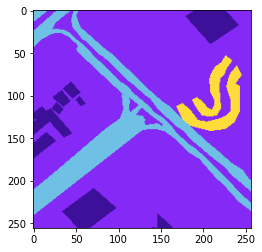

In [ ]:
label = single_patch_mask

#sense check, does it show an image
plt.imshow(label)

In [ ]:
def rgb_to_2d_label(label):
  """
  suppy mask lable as rgb
  converts pixels into label id (1,2,3 etc)
  """

  label_seg = np.zeros(label.shape, dtype=np.uint8)
  label_seg[np.all(label == Building, axis=-1)] = 0
  label_seg[np.all(label == Land, axis=-1)] = 1
  label_seg[np.all(label == Road, axis=-1)] = 2
  label_seg[np.all(label == Vegetation, axis=-1)] = 3
  label_seg[np.all(label == Water, axis=-1)] = 4
  label_seg[np.all(label == Unlabeled, axis=-1)] = 5

  # only take first channel, dont need the remaining
  label_seg = label_seg[:,:,0]
  
  return label_seg

In [ ]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_2d_label(mask_dataset[i])
  labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [ ]:
# sense check, confirm only lable ID values pressent
print(np.unique(labels))

[0 1 2 3 4 5]


In [ ]:
# Convert into one hot encoding
n_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, num_classes=n_classes)

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size=0.2, random_state=420)

print(X_train.shape) # sense check to ensure has been broken out 
print(X_test.shape)

(1044, 256, 256, 3)
(261, 256, 256, 3)


# Modeling

Segmentation model losses can be combined together and weighted... 

In [ ]:
# could play around with the sklearn class_weight function 
# but lets keep it simple and just take the same weights for each label

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666] # 1/6 for each label weight
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

## Model 1: Unet using custom loss function

In [ ]:
metrics = ['accuracy', jacard_coef]

def get_model():
  return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

In [ ]:
history1 = model.fit(X_train, y_train, 
                     batch_size = 16,
                     verbose=1,
                     epochs=100,
                     validation_data=(X_test,y_test),
                     shuffle=False)

Epoch 1/100
66/66 [==============================] - 22s 121ms/step - loss: 0.9912 - accuracy: 0.5798 - jacard_coef: 0.3080 - val_loss: 0.9926 - val_accuracy: 0.6256 - val_jacard_coef: 0.3468
Epoch 2/100
66/66 [==============================] - 7s 100ms/step - loss: 0.9615 - accuracy: 0.7137 - jacard_coef: 0.4487 - val_loss: 0.9792 - val_accuracy: 0.6580 - val_jacard_coef: 0.4531
Epoch 3/100
66/66 [==============================] - 7s 100ms/step - loss: 0.9508 - accuracy: 0.7425 - jacard_coef: 0.4968 - val_loss: 0.9694 - val_accuracy: 0.6797 - val_jacard_coef: 0.4621
Epoch 4/100
66/66 [==============================] - 7s 100ms/step - loss: 0.9466 - accuracy: 0.7517 - jacard_coef: 0.5154 - val_loss: 0.9693 - val_accuracy: 0.6692 - val_jacard_coef: 0.4685
Epoch 5/100
66/66 [==============================] - 7s 99ms/step - loss: 0.9433 - accuracy: 0.7601 - jacard_coef: 0.5330 - val_loss: 0.9611 - val_accuracy: 0.6957 - val_jacard_coef: 0.4962
Epoch 6/100
66/66 [==========================

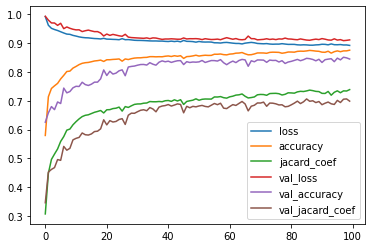

In [ ]:
pd.DataFrame(history1.history).plot()

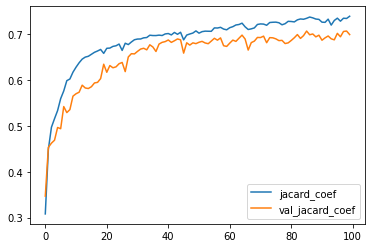

In [ ]:
pd.DataFrame(history1.history)[['jacard_coef', 'val_jacard_coef']].plot()

In [ ]:
# save model to GCP Bucket
model.save('/content/gcp_bucket/models/segment_unet_100e.hdf5')

## Model 2: resnet34 w pretrained weights

In [ ]:
# magic to make this work in colab
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

In [ ]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_preper = preprocess_input(X_train)
X_test_preper = preprocess_input(X_test)

# define model
model_resnet = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model_resnet.summary())

85532672/85521592 [==============================] - 1s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_68 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                       

In [ ]:
history2=model_resnet.fit(X_train_preper, 
          y_train,
          batch_size=16, 
          epochs=100,
          verbose=1,
          validation_data=(X_test_preper, y_test))

Epoch 1/100
66/66 [==============================] - 19s 189ms/step - loss: 0.8401 - accuracy: 0.7189 - jacard_coef: 0.4172 - val_loss: 4.7609 - val_accuracy: 0.1246 - val_jacard_coef: 0.0707
Epoch 2/100
66/66 [==============================] - 11s 161ms/step - loss: 0.6189 - accuracy: 0.7911 - jacard_coef: 0.5239 - val_loss: 24.2912 - val_accuracy: 0.1543 - val_jacard_coef: 0.0837
Epoch 3/100
66/66 [==============================] - 11s 160ms/step - loss: 0.5545 - accuracy: 0.8111 - jacard_coef: 0.5651 - val_loss: 1.6095 - val_accuracy: 0.4864 - val_jacard_coef: 0.1825
Epoch 4/100
66/66 [==============================] - 11s 160ms/step - loss: 0.5276 - accuracy: 0.8201 - jacard_coef: 0.5796 - val_loss: 1.8099 - val_accuracy: 0.5051 - val_jacard_coef: 0.2616
Epoch 5/100
66/66 [==============================] - 10s 159ms/step - loss: 0.5189 - accuracy: 0.8204 - jacard_coef: 0.5844 - val_loss: 1.9638 - val_accuracy: 0.5051 - val_jacard_coef: 0.2657
Epoch 6/100
66/66 [====================

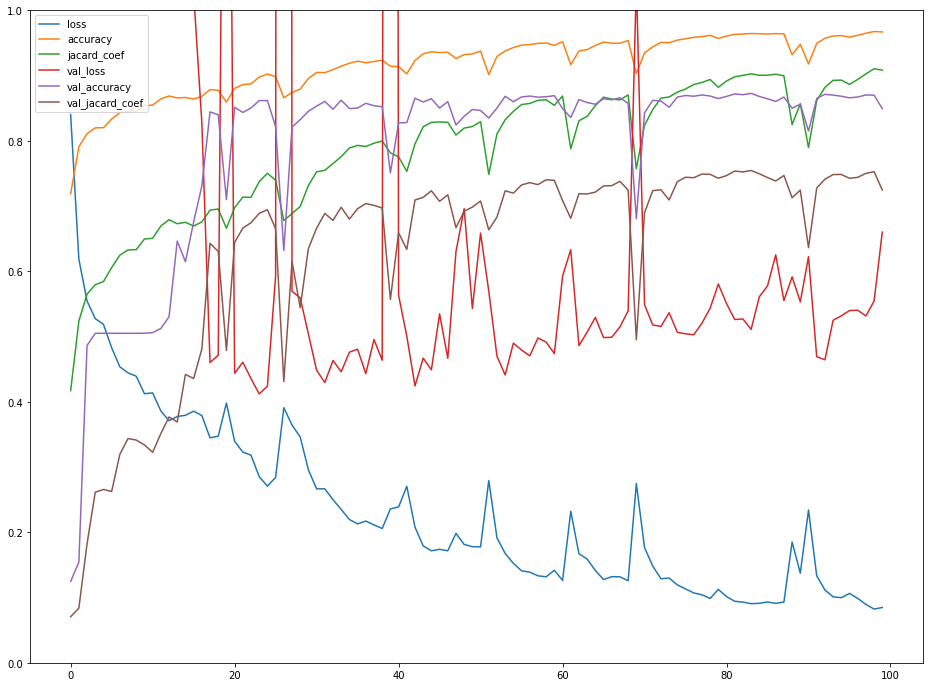

In [ ]:
pd.DataFrame(history2.history).plot(ylim=(0,1), figsize=(16,12))

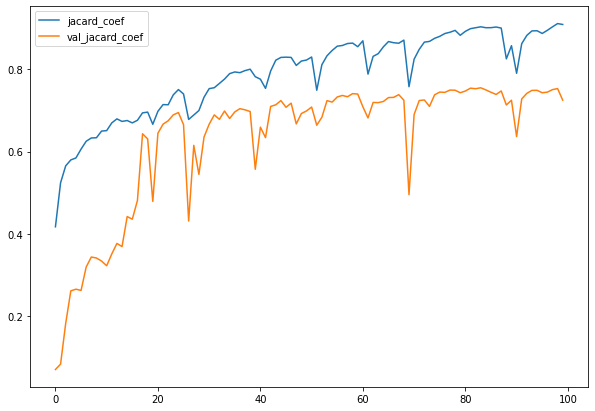

In [ ]:
pd.DataFrame(history2.history)[['jacard_coef', 'val_jacard_coef']].plot(figsize=(10,7))

In [ ]:
model_resnet.save('/content/gcp_bucket/models/segment_resnet34_std1.hdf5')

# Load Model & Predict

In [ ]:
# load Unet Model
from tensorflow.keras.models import load_model
model = load_model('/content/gcp_bucket/models/segment_unet_100e.hdf5',
                   custom_objects={'dice_loss_plus_1focal_loss':total_loss,
                                   'jacard_coef':jacard_coef}) # custome metrics previously used we must specify

# IOU 
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

# use keras function for IOU
n_classes = 6
IOU_keras = MeanIoU(num_classes = n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IOU =", IOU_keras.result().numpy())

Mean IOU = 0.58902735


In [ ]:
# Predict some images

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test_argmax[test_img_number]
#
test_img_input = np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]
predicted_img

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

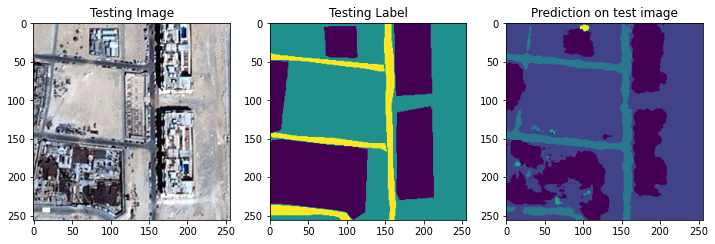

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

# we can see that the colors are not identical as plt is just using default
# we will change these colors later

# Smoothing & Blending Tiles
We will start from scratch, so importing model and all

In [ ]:
# load full image example

img = cv2.imread('/content/Semantic_seg_dataset/Semantic segmentation dataset/Tile 3/images/image_part_002.jpg')
origin_mask = cv2.imread('/content/Semantic_seg_dataset/Semantic segmentation dataset/Tile 3/masks/image_part_002.png')
origin_mask = cv2.cvtColor(origin_mask, cv2.COLOR_BGR2RGB)

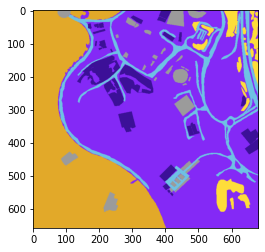

In [ ]:
plt.imshow(origin_mask)

In [ ]:
# import model
# model = load_model('/content/gcp_bucket/models/segment_unet_100e.hdf5',
#                    custom_objects={'dice_loss_plus_1focal_loss':total_loss,
#                                    'jacard_coef':jacard_coef}) # custome metrics previously used we must specify

# could do compile=False if we dont want to specicy the custom loss metrics
model = load_model('/content/gcp_bucket/models/segment_unet_100e.hdf5', compile=False) 

# set patch size 
patch_size = 256

# set number of classes
n_classes = 6

## Manual (no smoothing) approach

(-0.5, 511.5, 511.5, -0.5)

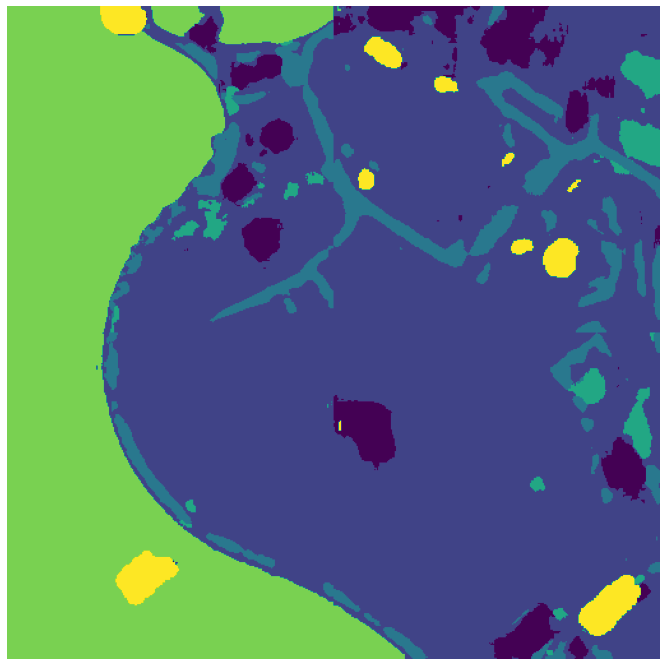

In [ ]:
# manual approach w no smooth blending ########

SIZE_X = (img.shape[1] // patch_size) * patch_size
SIZE_Y = (img.shape[0] // patch_size) * patch_size
large_img = Image.fromarray(img)
large_img = large_img.crop((0, 0, SIZE_X, SIZE_Y)) # crop from top left
large_img = np.array(large_img)

patches_img = patchify(large_img, (patch_size, patch_size, 3), step=patch_size) #step of 256 w no overlap
patches_img = patches_img[:,:,0,:,:,:]

patched_prediction = []
for i in range(patches_img.shape[0]):
  for j in range(patches_img.shape[1]):

    single_patch_img = patches_img[i,j,:,:,:]

    # like before we use minmax scaler instead of div by 255
    single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[1])).reshape(single_patch_img.shape)
    single_patch_img = np.expand_dims(single_patch_img, axis=0)
    pred = model.predict(single_patch_img)
    pred = np.argmax(pred, axis=3)
    pred = pred[0, :, :]

    patched_prediction.append(pred)

patched_prediction = np.array(patched_prediction)
patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1], patches_img.shape[2], patches_img.shape[3]])

unpatched_prediction = unpatchify(patched_prediction, (large_img.shape[0], large_img.shape[1]))

plt.figure(figsize=(12,12))
plt.imshow(unpatched_prediction)
plt.axis('off')

## Blended Approach
Always remember to preprocess your image in the same way <br>
The function below is thanks to https://github.com/Vooban/Smoothly-Blend-Image-Patches

In [ ]:
input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

predictions_smooth = predict_img_with_smooth_windowing(
    input_img,
    window_size=patch_size,
    subdivisions=2,  #min overlap, must be even num
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))))

final_prediction = np.argmax(predictions_smooth, axis=2)

100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


In [ ]:
# convert back to correct rgb color mask
prediction_w_smooth = label_to_rgb(final_prediction)
#prediction_wo_smooth = label_to_rgb(unpatched_prediction)

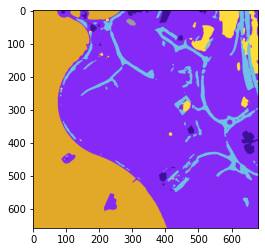

In [ ]:
plt.imshow(prediction_w_smooth)

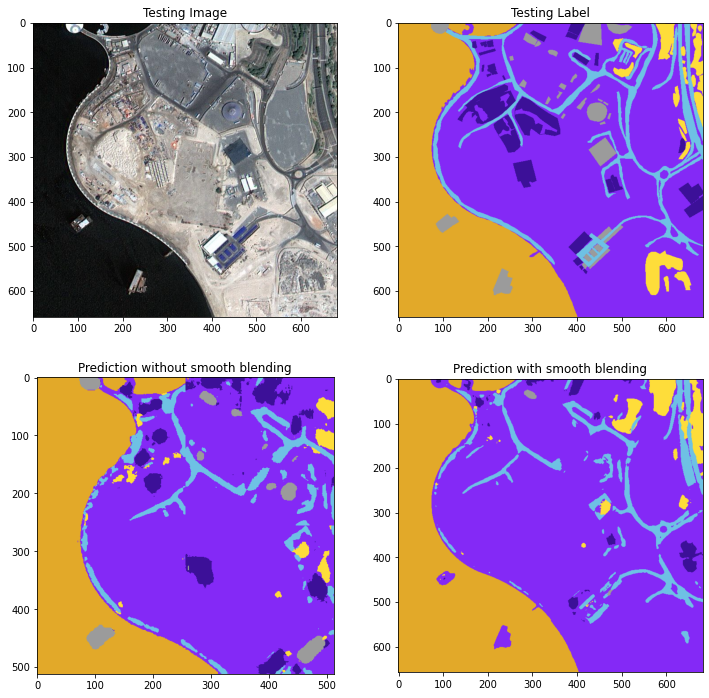

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Testing Label')
plt.imshow(origin_mask)
plt.subplot(223)
plt.title('Prediction without smooth blending')
plt.imshow(prediction_wo_smooth)
plt.subplot(224)
plt.title('Prediction with smooth blending')
plt.imshow(prediction_w_smooth)
plt.show()

# Predict on Other Images

In [ ]:
# create function for entier blended process
def pipeline_pred_smooth(image_location):
  """
  Takes an image directory and produces a segmentation mask using a smoothed edge tile approach

  0. input directory for image
  1. image scaled
  2. break image into tiles w overlapping pixels
  3. use model to predict segemntation on each tile
  4. convert array back to rgb
  5. display
  """
  img = cv2.imread(image_location)
  input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

  predictions_smooth = predict_img_with_smooth_windowing(
      input_img,
      window_size=patch_size,
      subdivisions=2,  
      nb_classes=n_classes,
      pred_func=(
          lambda img_batch_subdiv: model.predict((img_batch_subdiv))))

  final_prediction = np.argmax(predictions_smooth, axis=2)
  prediction_w_smooth = label_to_rgb(final_prediction) 

  plt.figure(figsize=(16, 16))
  plt.subplot(221)
  plt.title('Testing Image')
  plt.imshow(img)
  plt.axis('off')

  plt.subplot(222)
  plt.title('Prediction with smooth blending')
  plt.imshow(prediction_w_smooth)
  plt.axis('off')


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


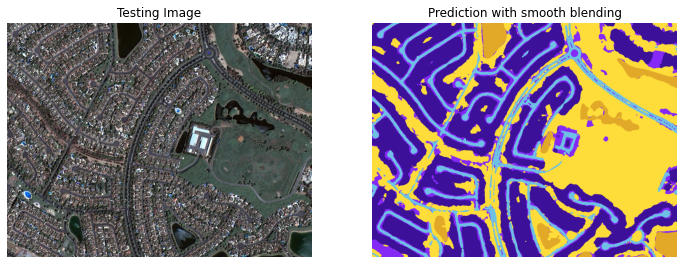

In [ ]:
pipeline_pred_smooth('/content/Semantic_seg_dataset/Semantic segmentation dataset/Tile 4/images/image_part_002.jpg')

In [ ]:
# show color labels



100%|██████████| 8/8 [00:26<00:00,  3.28s/it]


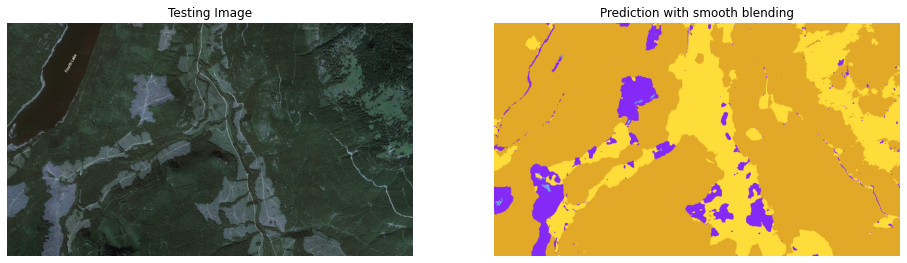

In [ ]:
# test with random google earth image

pipeline_pred_smooth('/content/Screen Shot 2022-05-17 at 6.26.46 PM.png')

100%|██████████| 8/8 [00:27<00:00,  3.40s/it]


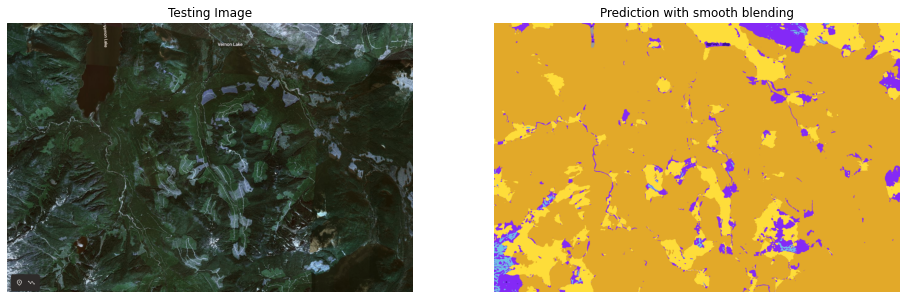

In [ ]:
pipeline_pred_smooth('/content/Screen Shot 2022-05-17 at 6.29.51 PM.png')

100%|██████████| 8/8 [00:16<00:00,  2.03s/it]


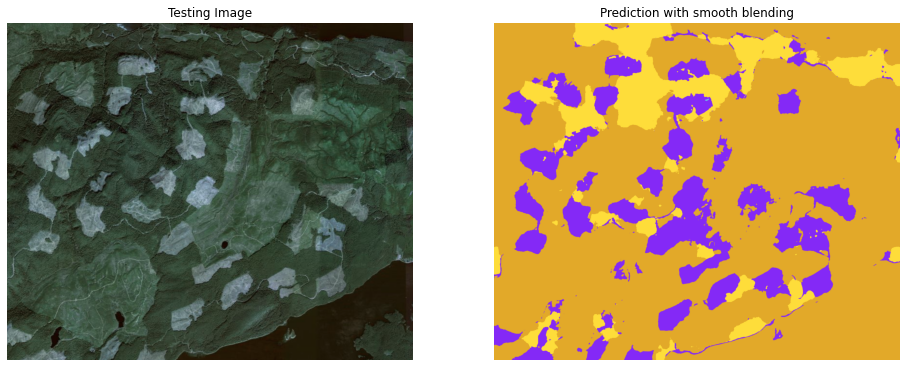

In [ ]:
pipeline_pred_smooth('/content/Screen Shot 2022-05-17 at 6.32.50 PM.png')

# Calculate % of image with pixels not forest to investigate

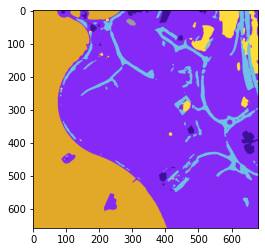

In [ ]:
plt.imshow(prediction_w_smooth)

In [ ]:
(prediction_w_smooth == Vegetation).all(axis=-1).sum()

12559

In [ ]:
prediction_w_smooth

array([[[226, 169,  41],
        [226, 169,  41],
        [226, 169,  41],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[226, 169,  41],
        [226, 169,  41],
        [226, 169,  41],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[226, 169,  41],
        [226, 169,  41],
        [226, 169,  41],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       ...,

       [[226, 169,  41],
        [226, 169,  41],
        [226, 169,  41],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[226, 169,  41],
        [226, 169,  41],
        [226, 169,  41],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[226, 169,  41],
        [226, 169,  41],
        [226, 169,  41],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]]

In [98]:
# RGB Lables

def calc_veg(image):  
  Building = (60, 16, 152)
  Land = (132, 41, 246)
  Road = (110, 193, 228)
  Vegetation = (254, 221, 58)
  Water = (226, 169, 41)
  Unlabeled = (155, 155, 155)

  pix_total = image.all(axis=-1).sum() # cont total pixels
  pix_building = (image == Building).all(axis=-1).sum()
  pix_land = (image == Land).all(axis=-1).sum()
  pix_road = (image == Road).all(axis=-1).sum()
  pix_vegetation = (image == Vegetation).all(axis=-1).sum()
  pix_water = (image == Water).all(axis=-1).sum()
  pix_unlabeled = (image == Unlabeled).all(axis=-1).sum()

  label_total = pix_building + pix_land + pix_road + pix_vegetation + pix_water + pix_unlabeled # this should = 0 as a test
  non_veg_total = pix_building + pix_land + pix_road + pix_water + pix_unlabeled

  veg_perc = pix_vegetation / pix_total

  calc = round(veg_perc, 3)

  return calc

In [99]:
calc_veg(prediction_w_smooth)

0.028

In [104]:
print('awake')

awake
